/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
/home/share/TmpData/Qinglin/HCP_4mm_GLM/GAMBLING/IC1_high.nii.gz


KeyboardInterrupt: 

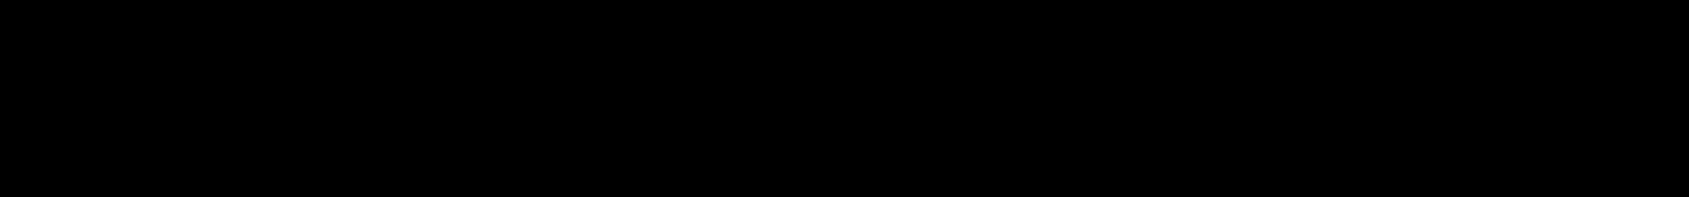

In [170]:
from nilearn.datasets import load_mni152_brain_mask
from nilearn import image
from nilearn.input_data import NiftiMasker

mask_img = load_mni152_brain_mask()
masker = NiftiMasker(mask_img=mask_img,standardize=True)
masker.fit()

def flip(row):
    if np.sum(row > 0) < np.sum(row < 0):
        row *= -1
        
def load_maps(file):
    print(file)
    GLM=image.load_img(file)
    maps_GLM=masker.transform(GLM)
#     for row in maps_GLM:
#         flip(row)
    maps_GLM[maps_GLM<0]=0
    return maps_GLM

# plot GLM map
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from pylab import figure
import os

def save_maps(components_img,dir):        
    if not os.path.exists(dir):
        os.makedirs(dir)
    
    for i, cur_img in enumerate(iter_img(components_img)):
        outname=dir+str(i)+'.png'
        plot_stat_map(cur_img, display_mode="z", black_bg=True,cut_coords=10,
                     colorbar=True,output_file=outname,title="Cope %d" % int(i+1))

tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
for task in tasks:
    file='/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz'
    maps_GLM=load_maps(file)
    maps_GLM = masker.inverse_transform(maps_GLM)
    dir='/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_GLM/'
    if not os.path.exists(dir):
        os.makedirs(dir)
    save_maps(maps_GLM,dir)        
 

In [174]:
import numpy as np
from scipy.spatial import distance
def MapOverlap( a, b):
    Intersect = np.logical_and(a, b)
    Union=np.logical_or(a, b)
    return np.count_nonzero(Intersect)/np.count_nonzero(Union)
def MapOverlap2( GLM, b):
    Intersect = np.logical_and(GLM, b)
    Union=np.logical_or(GLM, b)
    if np.count_nonzero(Union)   ==0:
        U=0
    else:
        U=np.count_nonzero(GLM)/np.count_nonzero(Union)   
    return np.count_nonzero(Intersect)/np.count_nonzero(GLM)-U
def MapHierach( a, b):
    I = np.count_nonzero(np.logical_and(a, b))
    A=np.count_nonzero(a)
    B=np.count_nonzero(b)
    return I/min([A,B])
def Euclid(a,b):
    a = np.where(a > 10e-6, 1, 0)
    b = np.where(b > 10e-6, 1, 0)
    np.count_nonzero(a-b)
from scipy.stats import entropy
def KL(a,b):
    return (entropy(a,b)+entropy(b,a))/2
from sklearn import metrics
def LayerOverlap(A,B):
    D=[]
    for i,a in enumerate(A):
        D.append([])
        
        for j,b in enumerate(B):
#             score=metrics.mutual_info_score(a,b)
            score=MapHierach(a,b)
#             score=KL(a,b)
#             score = Euclid(a,b)
            D[i].append(score)
    return D

In [141]:
# # plot all Overlap
# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sns
# def plot(D,file):
#     plt.ylim(1, 7)
#     plt.figure(figsize=(5,2))
#     sns_plot=sns.heatmap(D,cmap="Reds",vmax=1)
#     plt.savefig(file, bbox_inches='tight')
  
# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
# def run(task):
#     map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')
#     map2=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map2.npy')
#     map3=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map3.npy')
#     maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')
#     D1=LayerOverlap(maps_GLM,map1)
#     D2=LayerOverlap(maps_GLM,map2)
#     D3=LayerOverlap(maps_GLM,map3)
#     plot(D1,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D1.png')
#     plot(D2,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D2.png')
#     plot(D3,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D3.png')
# from joblib import Parallel, delayed
# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
# Parallel(n_jobs=7)(delayed(run)(task) for task in tasks)

  


In [161]:
# best match of 7 tasks
import operator
import numpy as np
from shutil import copyfile
import shutil
def match(task):
    map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')
    map2=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map2.npy')
    map3=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map3.npy')
    maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')

    D1=LayerOverlap(maps_GLM,map1)
    D2=LayerOverlap(maps_GLM,map2)
    D3=LayerOverlap(maps_GLM,map3)

    src='/home/share/TmpData/Qinglin/HCP_Group_DBN/Maps_ortho/'
    dst='/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_match/'
    shutil.rmtree(dst) 
    if not os.path.exists(dst):
            os.makedirs(dst)
    
    copyfile('/home/share/TmpData/Qinglin/HCP_4mm/100206/MNINonLinear/Results/tfMRI_'+task+'_LR/tfMRI_'+task+'_LR_hp200_s4.feat/design.png', dst+'design.png')
    for t in list(range(0,len(maps_GLM))):
#     for t in list(range(0,6)):
        index1, value = max(enumerate(D1[t]), key=operator.itemgetter(1))
        index2, value = max(enumerate(D2[t]), key=operator.itemgetter(1))
        index3, value = max(enumerate(D3[t]), key=operator.itemgetter(1))
        print(index1,index2,index3)        
        copyfile(src+task+'_W1/'+str(index1+1)+'.png', dst+str(t)+'_W1_'+str(index1+1)+'.png')
        copyfile(src+task+'_W2/'+str(index2+1)+'.png', dst+str(t)+'_W2_'+str(index1+1)+'.png')
        copyfile(src+task+'_W3/'+str(index3+1)+'.png', dst+str(t)+'_W3_'+str(index1+1)+'.png')
        
        copyfile('/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/EMOTION_GLM/'+str(t)+'.png', dst+str(t)+'.png')
        
match('EMOTION')        
# from joblib import Parallel, delayed
# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
# Parallel(n_jobs=7)(delayed(match)(task) for task in tasks)        

/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
88 18 71
88 88 8
88 54 71
88 80 89
88 76 89
88 88 89


In [198]:
# best match of 7 tasks
import operator
import numpy as np
from shutil import copyfile
import shutil
D1=[]        
cope=[0,1,1,1,4,1,1]
def match(i,task):
    map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')

    maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')
    maps_GLM=maps_GLM
        
    D=LayerOverlap(maps_GLM,map1)
    D1.append(D[cope[i]])




for i,task in enumerate(tasks):
    print(i, task)
    match(i,task)


    

0 EMOTION
/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
1 GAMBLING
/home/share/TmpData/Qinglin/HCP_4mm_GLM/GAMBLING/IC1_high.nii.gz
2 LANGUAGE
/home/share/TmpData/Qinglin/HCP_4mm_GLM/LANGUAGE/IC1_high.nii.gz
3 MOTOR
/home/share/TmpData/Qinglin/HCP_4mm_GLM/MOTOR/IC1_high.nii.gz
4 RELATIONAL
/home/share/TmpData/Qinglin/HCP_4mm_GLM/RELATIONAL/IC1_high.nii.gz
5 SOCIAL
/home/share/TmpData/Qinglin/HCP_4mm_GLM/SOCIAL/IC1_high.nii.gz
6 WM
/home/share/TmpData/Qinglin/HCP_4mm_GLM/WM/IC1_high.nii.gz


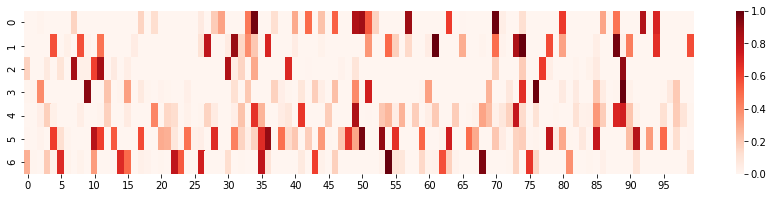

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot(D,file):
    plt.figure(figsize=(15,3))
    plt.ylim(1, 7)
    plt.xlim(1, 101)
#     plt.xlabel(1,100)
    sns_plot=sns.heatmap(D,cmap="Reds",vmax=1,xticklabels=5, yticklabels=1)
    plt.savefig(file, bbox_inches='tight')
  
plot(D1,'/home/uga_qinglin/Documents/All_D1.png')

In [180]:
D1[1].shape

AttributeError: 'list' object has no attribute 'shape'

In [154]:
print(a)
print(np.count_nonzero(a))
Jupyter Notebook
3.GLM Last Checkpoint: 12/08/2018 (autosaved) Current Kernel Logo 

Python 3

    File
    Edit
    View
    Insert
    Cell
    Kernel
    Widgets
    Help

from nilearn.datasets import load_mni152_brain_mask

from nilearn import image

from nilearn.input_data import NiftiMasker

​

mask_img = load_mni152_brain_mask()

masker = NiftiMasker(mask_img=mask_img,standardize=True)

masker.fit()

​

def flip(row):

    if np.sum(row > 0) < np.sum(row < 0):

        row *= -1

        

def load_maps(file):

    print(file)

    GLM=image.load_img(file)

    maps_GLM=masker.transform(GLM)

#     for row in maps_GLM:

#         flip(row)

    maps_GLM[maps_GLM<0]=0

    return maps_GLM

​

# plot GLM map

from nilearn.image import iter_img

from nilearn.plotting import plot_stat_map, show

from pylab import figure

import os

​

def save_maps(components_img,dir):        

    if not os.path.exists(dir):

        os.makedirs(dir)

    

    for i, cur_img in enumerate(iter_img(components_img)):

        outname=dir+str(i)+'.png'

        plot_stat_map(cur_img, display_mode="z", black_bg=True,cut_coords=10,

                     colorbar=True,output_file=outname,title="Cope %d" % int(i+1))

​

tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

for task in tasks:

    file='/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz'

    maps_GLM=load_maps(file)

    maps_GLM = masker.inverse_transform(maps_GLM)

    dir='/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_GLM/'

    if not os.path.exists(dir):

        os.makedirs(dir)

    save_maps(maps_GLM,dir)        

 

/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
/home/share/TmpData/Qinglin/HCP_4mm_GLM/GAMBLING/IC1_high.nii.gz

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
<ipython-input-170-8596760115fa> in <module>
     45     if not os.path.exists(dir):
     46         os.makedirs(dir)
---> 47     save_maps(maps_GLM,dir)
     48 

<ipython-input-170-8596760115fa> in save_maps(components_img, dir)
     35         outname=dir+str(i)+'.png'
     36         plot_stat_map(cur_img, display_mode="z", black_bg=True,cut_coords=10,
---> 37                      colorbar=True,output_file=outname,title="Cope %d" % int(i+1))
     38 
     39 tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/img_plotting.py in plot_stat_map(stat_map_img, bg_img, cut_coords, output_file, display_mode, colorbar, figure, axes, title, threshold, annotate, draw_cross, black_bg, cmap, symmetric_cbar, dim, vmax, resampling_interpolation, **kwargs)
   1030         bg_vmin=bg_vmin, bg_vmax=bg_vmax, cmap=cmap, vmin=vmin, vmax=vmax,
   1031         colorbar=colorbar, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,
-> 1032         resampling_interpolation=resampling_interpolation, **kwargs)
   1033 
   1034     return display

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/img_plotting.py in _plot_img_with_bg(img, bg_img, cut_coords, output_file, display_mode, colorbar, figure, axes, title, threshold, annotate, draw_cross, black_bg, vmin, vmax, bg_vmin, bg_vmax, interpolation, display_factory, cbar_vmin, cbar_vmax, brain_color, **kwargs)
    180         display.add_overlay(bg_img,
    181                             vmin=bg_vmin, vmax=bg_vmax,
--> 182                             cmap=plt.cm.gray, interpolation=interpolation)
    183 
    184     if img is not None and img is not False:

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/displays.py in add_overlay(self, img, threshold, colorbar, **kwargs)
    681         # with plot_stat_map
    682         kwargs.setdefault('interpolation', 'nearest')
--> 683         ims = self._map_show(img, type='imshow', threshold=threshold, **kwargs)
    684 
    685         # `ims` can be empty in some corner cases, look at test_img_plotting.test_outlier_cut_coords.

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/displays.py in _map_show(self, img, type, resampling_interpolation, threshold, **kwargs)
    765             not_mask = np.logical_not(data.mask)
    766             xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = \
--> 767                 get_mask_bounds(new_img_like(img, not_mask, affine))
    768 
    769         data_2d_list = []

/usr/local/lib/python3.5/dist-packages/nilearn/image/resampling.py in get_mask_bounds(img)
    206 
    207     """
--> 208     img = _utils.check_niimg_3d(img)
    209     mask = _utils.numpy_conversions._asarray(img.get_data(), dtype=np.bool)
    210     affine = img.affine

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/niimg_conversions.py in check_niimg_3d(niimg, dtype)
    320     Its application is idempotent.
    321     """
--> 322     return check_niimg(niimg, ensure_ndim=3, dtype=dtype)
    323 
    324 

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/niimg_conversions.py in check_niimg(niimg, ensure_ndim, atleast_4d, dtype, return_iterator, wildcards)
    269 
    270     # Otherwise, it should be a filename or a SpatialImage, we load it
--> 271     niimg = load_niimg(niimg, dtype=dtype)
    272 
    273     if ensure_ndim == 3 and len(niimg.shape) == 4 and niimg.shape[3] == 1:

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/niimg.py in load_niimg(niimg, dtype)
    114                         + short_repr(niimg))
    115 
--> 116     dtype = _get_target_dtype(niimg.get_data().dtype, dtype)
    117 
    118     if dtype is not None:

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/img_plotting.py in get_data(self)
    333 
    334     def get_data(self):
--> 335         self.load()
    336         return self.data
    337 

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/img_plotting.py in load(self)
    325             data = anat_img.get_data()
    326             data = data.astype(np.float)
--> 327             anat_mask = ndimage.morphology.binary_fill_holes(data > 0)
    328             data = np.ma.masked_array(data, np.logical_not(anat_mask))
    329             self._affine = anat_img.affine

KeyboardInterrupt: 

import numpy as np

from scipy.spatial import distance

def MapOverlap( a, b):

    Intersect = np.logical_and(a, b)

    Union=np.logical_or(a, b)

    return np.count_nonzero(Intersect)/np.count_nonzero(Union)

def MapOverlap2( GLM, b):

    Intersect = np.logical_and(GLM, b)

    Union=np.logical_or(GLM, b)

    if np.count_nonzero(Union)   ==0:

        U=0

    else:

        U=np.count_nonzero(GLM)/np.count_nonzero(Union)   

    return np.count_nonzero(Intersect)/np.count_nonzero(GLM)-U

def MapHierach( a, b):

    I = np.count_nonzero(np.logical_and(a, b))

    A=np.count_nonzero(a)

    B=np.count_nonzero(b)

    return I/min([A,B])

def Euclid(a,b):

    a = np.where(a > 10e-6, 1, 0)

    b = np.where(b > 10e-6, 1, 0)

    np.count_nonzero(a-b)

from scipy.stats import entropy

def KL(a,b):

    return (entropy(a,b)+entropy(b,a))/2

from sklearn import metrics

def LayerOverlap(A,B):

    D=[]

    for i,a in enumerate(A):

        D.append([])

        

        for j,b in enumerate(B):

#             score=metrics.mutual_info_score(a,b)

            score=MapHierach(a,b)

#             score=KL(a,b)

#             score = Euclid(a,b)

            D[i].append(score)

    return D

# # plot all Overlap

# %matplotlib inline

# import matplotlib.pyplot as plt

# import seaborn as sns

# def plot(D,file):

#     plt.ylim(1, 7)

#     plt.figure(figsize=(5,2))

#     sns_plot=sns.heatmap(D,cmap="Reds",vmax=1)

#     plt.savefig(file, bbox_inches='tight')

  

# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

# def run(task):

#     map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')

#     map2=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map2.npy')

#     map3=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map3.npy')

#     maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')

#     D1=LayerOverlap(maps_GLM,map1)

#     D2=LayerOverlap(maps_GLM,map2)

#     D3=LayerOverlap(maps_GLM,map3)

#     plot(D1,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D1.png')

#     plot(D2,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D2.png')

#     plot(D3,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D3.png')

# from joblib import Parallel, delayed

# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

# Parallel(n_jobs=7)(delayed(run)(task) for task in tasks)

​

  

​

# best match of 7 tasks

import operator

import numpy as np

from shutil import copyfile

import shutil

def match(task):

    map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')

    map2=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map2.npy')

    map3=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map3.npy')

    maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')

​

    D1=LayerOverlap(maps_GLM,map1)

    D2=LayerOverlap(maps_GLM,map2)

    D3=LayerOverlap(maps_GLM,map3)

​

    src='/home/share/TmpData/Qinglin/HCP_Group_DBN/Maps_ortho/'

    dst='/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_match/'

    shutil.rmtree(dst) 

    if not os.path.exists(dst):

            os.makedirs(dst)

    

    copyfile('/home/share/TmpData/Qinglin/HCP_4mm/100206/MNINonLinear/Results/tfMRI_'+task+'_LR/tfMRI_'+task+'_LR_hp200_s4.feat/design.png', dst+'design.png')

    for t in list(range(0,len(maps_GLM))):

#     for t in list(range(0,6)):

        index1, value = max(enumerate(D1[t]), key=operator.itemgetter(1))

        index2, value = max(enumerate(D2[t]), key=operator.itemgetter(1))

        index3, value = max(enumerate(D3[t]), key=operator.itemgetter(1))

        print(index1,index2,index3)        

        copyfile(src+task+'_W1/'+str(index1+1)+'.png', dst+str(t)+'_W1_'+str(index1+1)+'.png')

        copyfile(src+task+'_W2/'+str(index2+1)+'.png', dst+str(t)+'_W2_'+str(index1+1)+'.png')

        copyfile(src+task+'_W3/'+str(index3+1)+'.png', dst+str(t)+'_W3_'+str(index1+1)+'.png')

        

        copyfile('/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/EMOTION_GLM/'+str(t)+'.png', dst+str(t)+'.png')

        

match('EMOTION')        

# from joblib import Parallel, delayed

# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

# Parallel(n_jobs=7)(delayed(match)(task) for task in tasks)        

/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
88 18 71
88 88 8
88 54 71
88 80 89
88 76 89
88 88 89

# best match of 7 tasks

import operator

import numpy as np

from shutil import copyfile

import shutil

D1=[]        

cope=[0,1,1,1,4,1,1]

def match(i,task):

    map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')

​

    maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')

    maps_GLM=maps_GLM

        

    D=LayerOverlap(maps_GLM,map1)

    D1.append(D[cope[i]])

​

​

​

​

for i,task in enumerate(tasks):

    print(i, task)

    match(i,task)

​

​

    

0 EMOTION
/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
1 GAMBLING
/home/share/TmpData/Qinglin/HCP_4mm_GLM/GAMBLING/IC1_high.nii.gz
2 LANGUAGE
/home/share/TmpData/Qinglin/HCP_4mm_GLM/LANGUAGE/IC1_high.nii.gz
3 MOTOR
/home/share/TmpData/Qinglin/HCP_4mm_GLM/MOTOR/IC1_high.nii.gz
4 RELATIONAL
/home/share/TmpData/Qinglin/HCP_4mm_GLM/RELATIONAL/IC1_high.nii.gz
5 SOCIAL
/home/share/TmpData/Qinglin/HCP_4mm_GLM/SOCIAL/IC1_high.nii.gz
6 WM
/home/share/TmpData/Qinglin/HCP_4mm_GLM/WM/IC1_high.nii.gz

import matplotlib.pyplot as plt

import seaborn as sns

def plot(D,file):

    plt.figure(figsize=(15,3))

    plt.ylim(1, 7)

    plt.xlim(1, 101)

#     plt.xlabel(1,100)

    sns_plot=sns.heatmap(D,cmap="Reds",vmax=1,xticklabels=5, yticklabels=1)

    plt.savefig(file, bbox_inches='tight')

  

plot(D1,'/home/uga_qinglin/Documents/All_D1.png')

D1[1].shape

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-180-5e547fb9f471> in <module>
----> 1 D1[1].shape

AttributeError: 'list' object has no attribute 'shape'

print(a)

print(np.count_nonzero(a))

Jupyter Notebook
3.GLM Last Checkpoint: 12/08/2018 (autosaved) Current Kernel Logo 

Python 3

    File
    Edit
    View
    Insert
    Cell
    Kernel
    Widgets
    Help

from nilearn.datasets import load_mni152_brain_mask

from nilearn import image

from nilearn.input_data import NiftiMasker

​

mask_img = load_mni152_brain_mask()

masker = NiftiMasker(mask_img=mask_img,standardize=True)

masker.fit()

​

def flip(row):

    if np.sum(row > 0) < np.sum(row < 0):

        row *= -1

        

def load_maps(file):

    print(file)

    GLM=image.load_img(file)

    maps_GLM=masker.transform(GLM)

#     for row in maps_GLM:

#         flip(row)

    maps_GLM[maps_GLM<0]=0

    return maps_GLM

​

# plot GLM map

from nilearn.image import iter_img

from nilearn.plotting import plot_stat_map, show

from pylab import figure

import os

​

def save_maps(components_img,dir):        

    if not os.path.exists(dir):

        os.makedirs(dir)

    

    for i, cur_img in enumerate(iter_img(components_img)):

        outname=dir+str(i)+'.png'

        plot_stat_map(cur_img, display_mode="z", black_bg=True,cut_coords=10,

                     colorbar=True,output_file=outname,title="Cope %d" % int(i+1))

​

tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

for task in tasks:

    file='/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz'

    maps_GLM=load_maps(file)

    maps_GLM = masker.inverse_transform(maps_GLM)

    dir='/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_GLM/'

    if not os.path.exists(dir):

        os.makedirs(dir)

    save_maps(maps_GLM,dir)        

 

/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
/home/share/TmpData/Qinglin/HCP_4mm_GLM/GAMBLING/IC1_high.nii.gz

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
<ipython-input-170-8596760115fa> in <module>
     45     if not os.path.exists(dir):
     46         os.makedirs(dir)
---> 47     save_maps(maps_GLM,dir)
     48 

<ipython-input-170-8596760115fa> in save_maps(components_img, dir)
     35         outname=dir+str(i)+'.png'
     36         plot_stat_map(cur_img, display_mode="z", black_bg=True,cut_coords=10,
---> 37                      colorbar=True,output_file=outname,title="Cope %d" % int(i+1))
     38 
     39 tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/img_plotting.py in plot_stat_map(stat_map_img, bg_img, cut_coords, output_file, display_mode, colorbar, figure, axes, title, threshold, annotate, draw_cross, black_bg, cmap, symmetric_cbar, dim, vmax, resampling_interpolation, **kwargs)
   1030         bg_vmin=bg_vmin, bg_vmax=bg_vmax, cmap=cmap, vmin=vmin, vmax=vmax,
   1031         colorbar=colorbar, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,
-> 1032         resampling_interpolation=resampling_interpolation, **kwargs)
   1033 
   1034     return display

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/img_plotting.py in _plot_img_with_bg(img, bg_img, cut_coords, output_file, display_mode, colorbar, figure, axes, title, threshold, annotate, draw_cross, black_bg, vmin, vmax, bg_vmin, bg_vmax, interpolation, display_factory, cbar_vmin, cbar_vmax, brain_color, **kwargs)
    180         display.add_overlay(bg_img,
    181                             vmin=bg_vmin, vmax=bg_vmax,
--> 182                             cmap=plt.cm.gray, interpolation=interpolation)
    183 
    184     if img is not None and img is not False:

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/displays.py in add_overlay(self, img, threshold, colorbar, **kwargs)
    681         # with plot_stat_map
    682         kwargs.setdefault('interpolation', 'nearest')
--> 683         ims = self._map_show(img, type='imshow', threshold=threshold, **kwargs)
    684 
    685         # `ims` can be empty in some corner cases, look at test_img_plotting.test_outlier_cut_coords.

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/displays.py in _map_show(self, img, type, resampling_interpolation, threshold, **kwargs)
    765             not_mask = np.logical_not(data.mask)
    766             xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = \
--> 767                 get_mask_bounds(new_img_like(img, not_mask, affine))
    768 
    769         data_2d_list = []

/usr/local/lib/python3.5/dist-packages/nilearn/image/resampling.py in get_mask_bounds(img)
    206 
    207     """
--> 208     img = _utils.check_niimg_3d(img)
    209     mask = _utils.numpy_conversions._asarray(img.get_data(), dtype=np.bool)
    210     affine = img.affine

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/niimg_conversions.py in check_niimg_3d(niimg, dtype)
    320     Its application is idempotent.
    321     """
--> 322     return check_niimg(niimg, ensure_ndim=3, dtype=dtype)
    323 
    324 

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/niimg_conversions.py in check_niimg(niimg, ensure_ndim, atleast_4d, dtype, return_iterator, wildcards)
    269 
    270     # Otherwise, it should be a filename or a SpatialImage, we load it
--> 271     niimg = load_niimg(niimg, dtype=dtype)
    272 
    273     if ensure_ndim == 3 and len(niimg.shape) == 4 and niimg.shape[3] == 1:

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/niimg.py in load_niimg(niimg, dtype)
    114                         + short_repr(niimg))
    115 
--> 116     dtype = _get_target_dtype(niimg.get_data().dtype, dtype)
    117 
    118     if dtype is not None:

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/img_plotting.py in get_data(self)
    333 
    334     def get_data(self):
--> 335         self.load()
    336         return self.data
    337 

/usr/local/lib/python3.5/dist-packages/nilearn/plotting/img_plotting.py in load(self)
    325             data = anat_img.get_data()
    326             data = data.astype(np.float)
--> 327             anat_mask = ndimage.morphology.binary_fill_holes(data > 0)
    328             data = np.ma.masked_array(data, np.logical_not(anat_mask))
    329             self._affine = anat_img.affine

KeyboardInterrupt: 

import numpy as np

from scipy.spatial import distance

def MapOverlap( a, b):

    Intersect = np.logical_and(a, b)

    Union=np.logical_or(a, b)

    return np.count_nonzero(Intersect)/np.count_nonzero(Union)

def MapOverlap2( GLM, b):

    Intersect = np.logical_and(GLM, b)

    Union=np.logical_or(GLM, b)

    if np.count_nonzero(Union)   ==0:

        U=0

    else:

        U=np.count_nonzero(GLM)/np.count_nonzero(Union)   

    return np.count_nonzero(Intersect)/np.count_nonzero(GLM)-U

def MapHierach( a, b):

    I = np.count_nonzero(np.logical_and(a, b))

    A=np.count_nonzero(a)

    B=np.count_nonzero(b)

    return I/min([A,B])

def Euclid(a,b):

    a = np.where(a > 10e-6, 1, 0)

    b = np.where(b > 10e-6, 1, 0)

    np.count_nonzero(a-b)

from scipy.stats import entropy

def KL(a,b):

    return (entropy(a,b)+entropy(b,a))/2

from sklearn import metrics

def LayerOverlap(A,B):

    D=[]

    for i,a in enumerate(A):

        D.append([])

        

        for j,b in enumerate(B):

#             score=metrics.mutual_info_score(a,b)

            score=MapHierach(a,b)

#             score=KL(a,b)

#             score = Euclid(a,b)

            D[i].append(score)

    return D

# # plot all Overlap

# %matplotlib inline

# import matplotlib.pyplot as plt

# import seaborn as sns

# def plot(D,file):

#     plt.ylim(1, 7)

#     plt.figure(figsize=(5,2))

#     sns_plot=sns.heatmap(D,cmap="Reds",vmax=1)

#     plt.savefig(file, bbox_inches='tight')

  

# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

# def run(task):

#     map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')

#     map2=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map2.npy')

#     map3=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map3.npy')

#     maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')

#     D1=LayerOverlap(maps_GLM,map1)

#     D2=LayerOverlap(maps_GLM,map2)

#     D3=LayerOverlap(maps_GLM,map3)

#     plot(D1,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D1.png')

#     plot(D2,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D2.png')

#     plot(D3,'/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_D3.png')

# from joblib import Parallel, delayed

# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

# Parallel(n_jobs=7)(delayed(run)(task) for task in tasks)

​

  

​

# best match of 7 tasks

import operator

import numpy as np

from shutil import copyfile

import shutil

def match(task):

    map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')

    map2=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map2.npy')

    map3=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map3.npy')

    maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')

​

    D1=LayerOverlap(maps_GLM,map1)

    D2=LayerOverlap(maps_GLM,map2)

    D3=LayerOverlap(maps_GLM,map3)

​

    src='/home/share/TmpData/Qinglin/HCP_Group_DBN/Maps_ortho/'

    dst='/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/'+task+'_match/'

    shutil.rmtree(dst) 

    if not os.path.exists(dst):

            os.makedirs(dst)

    

    copyfile('/home/share/TmpData/Qinglin/HCP_4mm/100206/MNINonLinear/Results/tfMRI_'+task+'_LR/tfMRI_'+task+'_LR_hp200_s4.feat/design.png', dst+'design.png')

    for t in list(range(0,len(maps_GLM))):

#     for t in list(range(0,6)):

        index1, value = max(enumerate(D1[t]), key=operator.itemgetter(1))

        index2, value = max(enumerate(D2[t]), key=operator.itemgetter(1))

        index3, value = max(enumerate(D3[t]), key=operator.itemgetter(1))

        print(index1,index2,index3)        

        copyfile(src+task+'_W1/'+str(index1+1)+'.png', dst+str(t)+'_W1_'+str(index1+1)+'.png')

        copyfile(src+task+'_W2/'+str(index2+1)+'.png', dst+str(t)+'_W2_'+str(index1+1)+'.png')

        copyfile(src+task+'_W3/'+str(index3+1)+'.png', dst+str(t)+'_W3_'+str(index1+1)+'.png')

        

        copyfile('/home/share/TmpData/Qinglin/HCP_Group_DBN/GLM/EMOTION_GLM/'+str(t)+'.png', dst+str(t)+'.png')

        

match('EMOTION')        

# from joblib import Parallel, delayed

# tasks=['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']

# Parallel(n_jobs=7)(delayed(match)(task) for task in tasks)        

/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
88 18 71
88 88 8
88 54 71
88 80 89
88 76 89
88 88 89

# best match of 7 tasks

import operator

import numpy as np

from shutil import copyfile

import shutil

D1=[]        

cope=[0,1,1,1,4,1,1]

def match(i,task):

    map1=np.load('/home/share/TmpData/Qinglin/HCP_Group_DBN/'+task+'_map1.npy')

​

    maps_GLM=load_maps('/home/share/TmpData/Qinglin/HCP_4mm_GLM/'+task+'/IC1_high.nii.gz')

    maps_GLM=maps_GLM

        

    D=LayerOverlap(maps_GLM,map1)

    D1.append(D[cope[i]])

​

​

​

​

for i,task in enumerate(tasks):

    print(i, task)

    match(i,task)

​

​

    

0 EMOTION
/home/share/TmpData/Qinglin/HCP_4mm_GLM/EMOTION/IC1_high.nii.gz
1 GAMBLING
/home/share/TmpData/Qinglin/HCP_4mm_GLM/GAMBLING/IC1_high.nii.gz
2 LANGUAGE
/home/share/TmpData/Qinglin/HCP_4mm_GLM/LANGUAGE/IC1_high.nii.gz
3 MOTOR
/home/share/TmpData/Qinglin/HCP_4mm_GLM/MOTOR/IC1_high.nii.gz
4 RELATIONAL
/home/share/TmpData/Qinglin/HCP_4mm_GLM/RELATIONAL/IC1_high.nii.gz
5 SOCIAL
/home/share/TmpData/Qinglin/HCP_4mm_GLM/SOCIAL/IC1_high.nii.gz
6 WM
/home/share/TmpData/Qinglin/HCP_4mm_GLM/WM/IC1_high.nii.gz

import matplotlib.pyplot as plt

import seaborn as sns

def plot(D,file):

    plt.figure(figsize=(15,3))

    plt.ylim(1, 7)

    plt.xlim(1, 101)

#     plt.xlabel(1,100)

    sns_plot=sns.heatmap(D,cmap="Reds",vmax=1,xticklabels=5, yticklabels=1)

    plt.savefig(file, bbox_inches='tight')

  

plot(D1,'/home/uga_qinglin/Documents/All_D1.png')

D1[1].shape

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-180-5e547fb9f471> in <module>
----> 1 D1[1].shape

AttributeError: 'list' object has no attribute 'shape'

print(a)

print(np.count_nonzero(a))

[0 0 0 ... 0 0 0]
15003

b=map1[2]

c=a-b

print(np.count_nonzero(b))

print(np.count_nonzero(c))

1150
16135

​


[0 0 0 ... 0 0 0]
15003

b=map1[2]

c=a-b

print(np.count_nonzero(b))

print(np.count_nonzero(c))

1150
16135

​



[0 0 0 ... 0 0 0]
15003


In [155]:
b=map1[2]
c=a-b

In [157]:
print(np.count_nonzero(b))
print(np.count_nonzero(c))

1150
16135
